In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [5]:
def load_series(algorithm: str, upper_bound: str, task_name: str, root_dir: str):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'AF'
    """

    res = []
    for name in os.listdir(root_dir):
        if not os.path.isdir(os.path.join(root_dir, name)):
            algo, up, task, b = name.strip()[:-5].split('-')
            algo, up, task, b = name.strip()[:-5].split('-')
            if algo == algorithm and up == upper_bound and task == task_name:
                # print(name)
                file_path = os.path.join(root_dir, name)
                with open(file_path, "rb") as rd:
                    kv_data = pickle.load(rd)
                res.append( (eval(b), kv_data['f(S)'], kv_data['Lambda'], kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    print(res)
    X, Y, Z, W = list(zip(*res))   # change it to two columns
    return X, Y, Z, W

def load_streaming_series(algorithm: str, upper_bound: str, task_name: str, root_dir: str):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'Time'
    """

    res = []
    for name in os.listdir(root_dir):
        if not os.path.isdir(os.path.join(root_dir, name)):
            algo, up, task, b = name.strip()[:-5].split('-')
            if algo == algorithm and up == upper_bound and task == task_name:
                # print(name)
                file_path = os.path.join(root_dir, name)
                with open(file_path, "rb") as rd:
                    kv_data = pickle.load(rd)
                res.append( (eval(b), kv_data['f(S)'], kv_data['Lambda'], kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    #print(res)
    X, Y, Z, W = list(zip(*res))   # change it to two columns
    return X, Y, Z, W


In [3]:
# alpha, beta, gamma, c2, d, c, e, MDAF
def load_custom_series(root_dir):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'AF'
    """

    res = []
    for name in os.listdir(root_dir):
        _, alpha, beta, gamma, n, seed = name.strip()[:-5].split('-')

            # print(name)
        file_path = os.path.join(root_dir, name)
        with open(file_path, "rb") as rd:
            kv_data = pickle.load(rd)
        res.append((alpha, beta, gamma, kv_data['c2'], kv_data['d'], kv_data['curvature'], kv_data['e'], kv_data['MDAF'],n, seed))

    res = sorted(res, key=lambda x: x[0])
    
    alpha, beta, gamma, c2, d, c, e, MDAF, n,seed = list(zip(*res))   # change it to two columns
    return alpha, beta, gamma, c2, d, c, e, MDAF,n, seed

Diagramming 

+ Each row has 2 columns.
+ Each row denotes a different task.
+ Y axis of 1st column denotes f(S) and Y axis of 2nd column denotes AF.
+ In each subfigure, X axis is budget. Different color denotes different (algorithm, upper-bound) combination.

Analysis Result
+ UB3 <= UB1
+ greedy max has better approximation ratio than mgreedy

a:0.2,b:0.1,g:0.1,n:100,s:0,MDAF:1.294279639339089
mean:0.9613312386355901


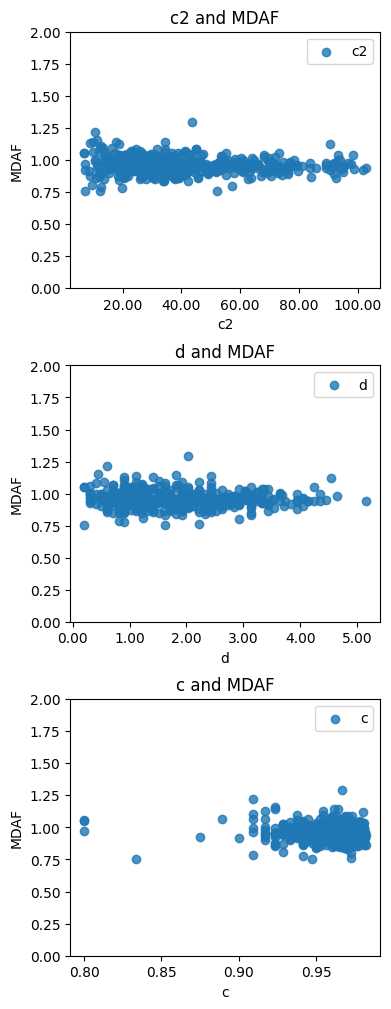

In [9]:
result_root_dir = "../result/custom-coverage-k-t"

# Each row contains one parameter
# alpha
# beta
# gamma
# seed
# c2
# d
# c
# e
alpha, beta, gamma, c2, d, c, e, MDAF,n, seed = load_custom_series(result_root_dir)

f = []

for i in range(0, len(c2)):
    f.append(c2[i]/d[i])

max_mdaf = 0
max_i = -1
for i in range(0, len(MDAF)):
    if MDAF[i] > max_mdaf:
        max_mdaf = MDAF[i]
        max_i = i
print(f"a:{alpha[max_i]},b:{beta[max_i]},g:{gamma[max_i]},n:{n[max_i]},s:{seed[max_i]},MDAF:{MDAF[max_i]}")
print(f"mean:{np.mean(MDAF)}")

max_mdaf = 0
max_config = None

parameters_names = [
    #"alpha", 
    #"beta", 
    #"gamma", 
    "c2", 
    "d", 
    "c", 
    #"e",
    #"f"
]

parameter_list = [
    #alpha, 
    #beta, 
    #gamma, 
    c2, 
    d, 
    c, 
    #e,
    #f
]

rows = len(parameters_names)
cols = 1
height, width = 4,4
fig, axes = plt.subplots(rows, 1, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})


for ax, parameter_name, parameter in zip(axes, parameters_names, parameter_list):
    ax.set_xlabel(parameter_name)
    ax.set_ylabel("MDAF")
    ax.set_title(f"{parameter_name} and MDAF")

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    ax.set_ylim(0.0, 2)

    ax.scatter(parameter, MDAF, label=parameter_name, alpha=0.8)

    ax.legend()
    
plt.show()

In [6]:
def combine_similar_elements(input: list, MDAF: list, eps: float = 0.01):
    assert len(input) == len(MDAF), "Inconsisitent"

    output = []

    output_mdaf_list = {}

    output_mdaf = []

    for idx in range(0, len(input)):
        e = input[idx]

        merged = False
        for center in output:
            if abs(e-center) < eps:
                merged = True
                output_mdaf_list[center].append(MDAF[idx])
                break

        if not merged:
            output.append(e)
            output_mdaf_list[e] = [MDAF[idx]]

    for center in output:
        mdaf_list = output_mdaf_list[center]
        output_mdaf.append(np.mean(mdaf_list))

    return output, output_mdaf

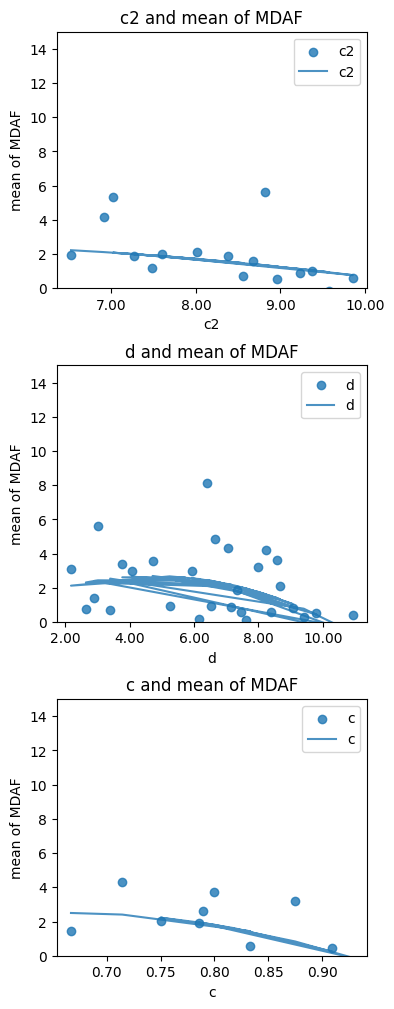

In [7]:
result_root_dir = "../result/custom-coverage-additive"

# Each row contains one parameter
# alpha
# beta
# gamma
# seed
# c2
# d
# c
# e
alpha, beta, gamma, c2, d, c, e, MDAF,n, seed = load_custom_series(result_root_dir)

f = []

for i in range(0, len(c2)):
    f.append(c2[i]/d[i])

c2, c2_mdaf = combine_similar_elements(c2, MDAF, eps=0.1)
d, d_mdaf = combine_similar_elements(d, MDAF, eps=0.1)
c, c_mdaf = combine_similar_elements(c, MDAF, eps=1e-4)
e, e_mdaf = combine_similar_elements(e, MDAF, eps=0.1)
f, f_mdaf = combine_similar_elements(f, MDAF, eps=0.1)

parameters_names = [
    #"alpha", 
    #"beta", 
    #"gamma", 
    "c2", 
    "d", 
    "c", 
    #"e",
    #"f"
]

parameter_list = [
    #alpha, 
    #beta, 
    #gamma, 
    c2, 
    d, 
    c, 
    #e,
    #f
]

MDAF_list = [
    c2_mdaf,
    d_mdaf,
    c_mdaf,
    #e_mdaf,
    #f_mdaf
]

rows = len(parameters_names)
cols = 1
height, width = 4,4
fig, axes = plt.subplots(rows, 1, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})


for ax, parameter_name, parameter, vmdaf in zip(axes, parameters_names, parameter_list, MDAF_list):
    ax.set_xlabel(parameter_name)
    ax.set_ylabel("mean of MDAF")
    ax.set_title(f"{parameter_name} and mean of MDAF")

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    ax.set_ylim(0.0, 15)

    f = np.polyfit(parameter, vmdaf, 2)
    p = np.poly1d(f)
    fvmdaf = p(parameter)

    ax.scatter(parameter, vmdaf, label=parameter_name, alpha=0.8)
    ax.plot(parameter, fvmdaf, label=parameter_name, alpha=0.8)

    ax.legend()
    
plt.show()

[(5.0, 2.0, 2.1999999999999984, 0.9090909090909097), (6.0, 2.3, 2.499999999999999, 0.9200000000000003), (7.0, 2.6, 2.799999999999999, 0.9285714285714289), (8.0, 2.8, 3.0999999999999988, 0.9032258064516132), (9.0, 3.0, 3.3999999999999986, 0.882352941176471), (10.0, 3.2, 3.6000000000000014, 0.8888888888888886), (11.0, 3.4, 3.8000000000000016, 0.8947368421052627), (12.0, 3.6, 4.000000000000002, 0.8999999999999996), (13.0, 3.8, 4.200000000000002, 0.9047619047619043), (14.0, 4.0, 4.400000000000002, 0.9090909090909086)]
[(5.0, 2.0, 2.1999999999999984, 0.9090909090909097), (6.0, 2.3, 2.4999999999999982, 0.9200000000000006), (7.0, 2.6, 2.799999999999998, 0.9285714285714293), (8.0, 2.8, 3.05, 0.9180327868852459), (9.0, 3.0, 3.25, 0.9230769230769231), (10.0, 3.2, 3.45, 0.927536231884058), (11.0, 3.4, 3.6500000000000004, 0.9315068493150683), (12.0, 3.6, 3.8500000000000005, 0.9350649350649349), (13.0, 3.8, 4.050000000000001, 0.9382716049382714), (14.0, 4.0, 4.250000000000001, 0.9411764705882351)]


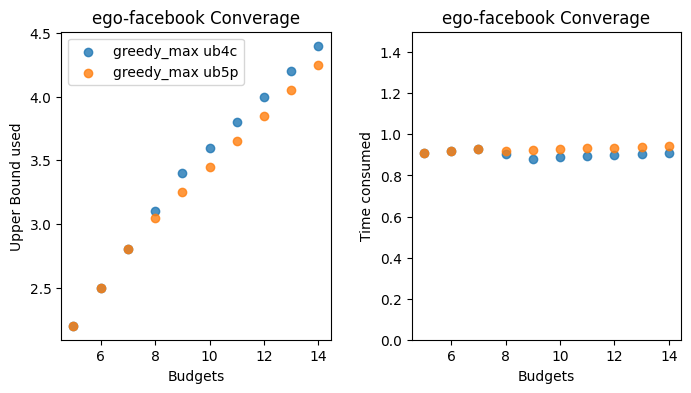

In [8]:
upper_bounds = ["ub4c","ub5p"]
algos = ["greedy_max"]
#task_names = ["DblpGraphCoverage"]
task_names = ["FacebookGraphCoverage"]
# task_names = ["IdealMaxCovModel"]
# task_names = ["MovieRecommendation"]
# task_names = ["CustomCoverage"]
# task_names = ["RevenueMax", "IdealMaxCovModel", "MovieRecommendation", "ImageSummarization"]


task2title = {
    #"RevenueMax": "Revenue Maximization", 
    #"IdealMaxCovModel": "Maximum Coverage", 
    "MovieRecommendation": "Movie Recommendation", 
    #"ImageSummarization": "Image Summarization",
    "DblpGraphCoverage":"com-dblp Converage",
    "FacebookGraphCoverage":"ego-facebook Converage",
    "CustomCoverage":"custom Coverage"
}
result_root_dir = "../result"


rows = len(task_names)
cols = 2
height, width = 4,4
fig, axes = plt.subplots(rows, cols, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})

if rows == 1:
    left_ax, right_ax = axes
    task_name = task_names[0]

    left_ax.set_xlabel("Budgets")
    left_ax.set_ylabel("Upper Bound used")
    left_ax.set_title(task2title[task_name])
    if task_name == "RevenueMax":
        left_ax.set_ylim(-5, 140)

    right_ax.set_xlabel("Budgets")
    right_ax.set_ylabel("Time consumed")
    right_ax.set_ylim(0.0, 1.5)
    right_ax.set_title(task2title[task_name])

    for algo in algos:
        X, Y, Z, W = load_series(algos[0], upper_bounds[0], task_name, result_root_dir)
        left_ax.scatter(X,Y,label="{}".format(algo), alpha = 0.8)
        for up in upper_bounds:
            X, Y, Z, W = load_series(algo, up, task_name, result_root_dir)

            # function value: same algorithm should have same function value
            # left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

            left_ax.scatter(X, Z, label="{} {}".format(algo, up), alpha=0.8)
            
            # TODO: floor and ceiling
            #W = np.minimum(np.ones(shape=len(W)), np.array(W))
            #W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
            right_ax.scatter(X, W, label="{} {}".format(algo, up), alpha=0.8)

    left_ax.legend()
    # middle_ax.legend()
    # right_ax.legend()
else:
    for row_axes, task_name in zip(axes, task_names):
        left_ax, middle_ax, right_ax = list(row_axes)

        left_ax.set_xlabel("Budgets")
        left_ax.set_ylabel("Function Value")
        left_ax.set_title(task2title[task_name])
        middle_ax.set_xlabel("Budgets")
        middle_ax.set_ylabel("Upper Bound used")
        middle_ax.set_title(task2title[task_name])
        if task_name == "RevenueMax":
            middle_ax.set_ylim(-5, 140)

        right_ax.set_xlabel("Budgets")
        right_ax.set_ylabel("Time consumed")
        right_ax.set_ylim(0.0, 1.5)
        right_ax.set_title(task2title[task_name])

        for algo in algos:
            for up in upper_bounds:
                X, Y, Z, W = load_series(algo, up, task_name, result_root_dir)

                if up == "ub1":
                    # function value: same algorithm should have same function value
                    left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

                middle_ax.scatter(X, Z, label="{} {}".format(algo, up), alpha=0.8)
                
                # TODO: floor and ceiling
                W = np.minimum(np.ones(shape=len(W)), np.array(W))
                W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
                right_ax.scatter(X, W, label="{} {}".format(algo, up), alpha=0.8)

        left_ax.legend()
        middle_ax.legend()
        # right_ax.legend()
    
plt.show()

# Misc

Categories
+ Upper bound 1 and 2
+ MGreedy and GreedyMax

In [ ]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

upper_bounds = ["ub1", "ub3"]
algos = ["modified_greedy", "greedy_max"]
X, Y = load_series("modified_greedy", "ub1")

In [ ]:
face_colors = [
    ['#FB4570', 'none', '#81B622'],
    ['#145DA0', 'none', '#EFEBE0'],
]

edge_colors = [
    ['#FB4570', '#3D550C', '#81B622'],
    ['#145DA0', '#FB8DA0', '#FB8DA0'],
]

fig, axes = plt.subplots(1,2, figsize=(10,5))


for r, algo in enumerate(algos):
    ax = axes[r]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        ax.scatter(X, Y, s=80, facecolors=face_colors[r][c], edgecolors=edge_colors[r][c], alpha=0.6, label='{} {}'.format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Approximation Ratio")
        ax.set_ylim([0., 1.2])
        ax.axhline(y = 1.0, color='r', linestyle='-')
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()

In [ ]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['Lambda']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

fig, axes = plt.subplots(1,2, figsize=(10,5))

for r, algo in enumerate(algos):
    ax = axes[0]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        print(algo, up)
        print(Y)
        ax.plot(X, Y, label="{} {}".format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Function Value")
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()